In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/filtered_events_country_code.csv')
print(df['event_type'].unique())
print(df['sub_event_type'].unique())
print(df['disorder_type'].unique())

['Protests' 'Riots']
['Peaceful protest' 'Protest with intervention' 'Violent demonstration'
 'Excessive force against protesters']
['Demonstrations' 'Political violence; Demonstrations']


In [3]:
df["violent"] = "NoN"
df.head()
df.to_csv('../data/violent_bool.csv', index=False)

In [4]:
for index, row in df.iterrows():
    if row["sub_event_type"] == "Peaceful protest" or row["sub_event_type"] == "Protest with intervention":
        df.at[index, "violent"] = 0
    elif row["sub_event_type"] == "Violent demonstration" or row["sub_event_type"] == "Excessive force against protesters":
        df.at[index, "violent"] = 1
df.to_csv('../data/violent_bool.csv', index=False)
print(df['violent'].value_counts())

violent
0    178686
1      4394
Name: count, dtype: int64


In [5]:
df['country_code'] = df['event_id_cnty'].astype(str).str[:3]
country_code_counts = df['country_code'].value_counts()

violent_counts = df[df['violent'] == 1]['country_code'].value_counts()
non_violent_counts = df[df['violent'] == 0]['country_code'].value_counts()
total_counts = df['country_code'].value_counts()

country_counts = pd.DataFrame({
    'violent': violent_counts,
    'non_violent': non_violent_counts,
    'total': total_counts
}).fillna(0)
country_counts['violent_percentage'] = (country_counts['violent'] / (country_counts['violent'] + country_counts['non_violent'])) * 100
country_counts.to_csv('../data/violent_per_country.csv')

In [6]:
print(country_counts.sort_values(by='violent_percentage', ascending=False))


              violent  non_violent  total  violent_percentage
country_code                                                 
GRC             588.0         4082   4670           12.591006
ALB             135.0         1116   1251           10.791367
FRA            1432.0        37342  38774            3.693196
NLD             142.0         4238   4380            3.242009
CHE              29.0         1012   1041            2.785783
CYP              48.0         1736   1784            2.690583
DEU             578.0        23214  23792            2.429388
AUT              49.0         1984   2033            2.410231
GBR             178.0         8032   8210            2.168088
ESP             400.0        20364  20764            1.926411
MDA              29.0         1676   1705            1.700880
ITA             430.0        25006  25436            1.690517
LUX               3.0          191    194            1.546392
BEL              61.0         4002   4063            1.501354
BIH     

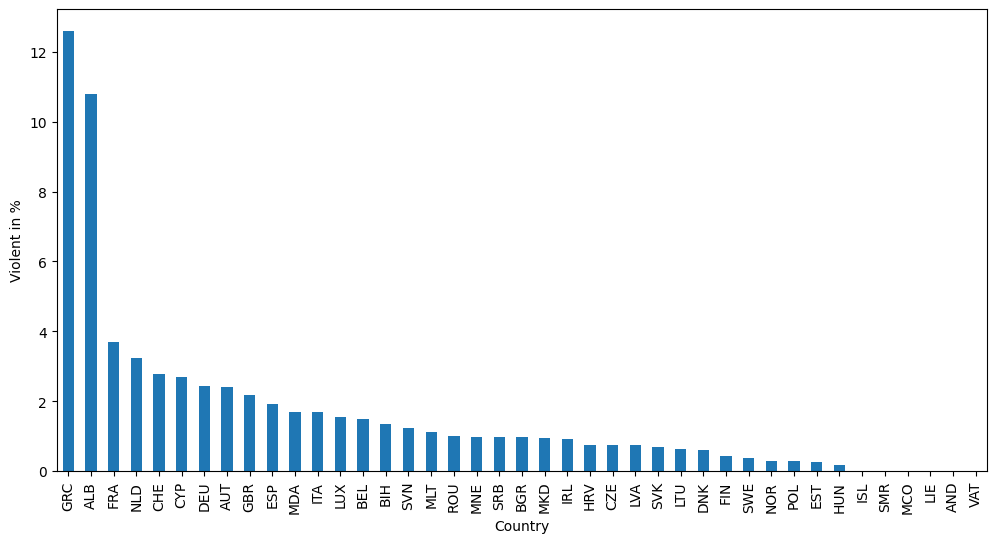

In [7]:
import matplotlib.pyplot as plt

# bar plot of violent events per country
country_counts.sort_values(by='violent_percentage', ascending=False).plot(
    kind='bar',
    y='violent_percentage',
    legend=False,
    figsize=(12, 6),
    xlabel='Country',
    ylabel='Violent in %'
)
plt.show()

In [8]:
df = df.dropna(subset=['assoc_actor_1'])
df['assoc_actor_1'] = df['assoc_actor_1'].str.split(';')
df = df.explode('assoc_actor_1')
df['assoc_actor_1'] = df['assoc_actor_1'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df.to_csv('../data/violent_dataset.csv', index=False)

violent_actor_counts = df[df['violent'] == 1]['assoc_actor_1'].value_counts()
non_violent_actor_counts = df[df['violent'] == 0]['assoc_actor_1'].value_counts()
total_actor_counts = df['assoc_actor_1'].value_counts()

actor_counts = pd.DataFrame({
    'violent': violent_actor_counts,
    'non_violent': non_violent_actor_counts,
    'total': total_actor_counts
}).fillna(0)

actor_counts['violent_percentage'] = (actor_counts['violent'] / (actor_counts['violent'] + actor_counts['non_violent'])) * 100
actor_counts.to_csv('../data/violent_per_actor.csv')
print(actor_counts)

                               violent  non_violent  total  violent_percentage
assoc_actor_1                                                                 
1 of 5 Million                     1.0        678.0    679            0.147275
100% Animalisti                    1.0         41.0     42            2.380952
1030/0 Collective                  0.0          1.0      1            0.000000
18 April Committee                 0.0          7.0      7            0.000000
269 LA: 269 Animal Liberation      0.0          3.0      3            0.000000
...                                ...          ...    ...                 ...
Zero Waste Europe                  0.0          5.0      5            0.000000
ZeroCovid                          0.0         10.0     10            0.000000
Zimbabwean Group                   0.0          1.0      1            0.000000
Zouaves Paris                      0.0          1.0      1            0.000000
sp.a: Flemish Socialist Party      0.0          5.0 

In [9]:
print(actor_counts.sort_values(by='violent_percentage', ascending=False))

                                  violent  non_violent  total  \
assoc_actor_1                                                   
BNP: British National Party           2.0          0.0      2   
Vigilante Group                       2.0          0.0      2   
SLD: Democratic Left Alliance         1.0          0.0      1   
Revolutionary Struggle                1.0          0.0      1   
Will                                  1.0          0.0      1   
...                                   ...          ...    ...   
Government of the People APS          0.0          3.0      3   
Government of the Czech Republic      0.0         42.0     42   
Government of Ukraine                 0.0         65.0     65   
Government of Turkey                  0.0          1.0      1   
sp.a: Flemish Socialist Party         0.0          5.0      5   

                                  violent_percentage  
assoc_actor_1                                         
BNP: British National Party                 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


X = df[['country_code', 'assoc_actor_1']]
y = df['violent']
data = pd.concat([X, y], axis=1).dropna()

X = data[['country_code', 'assoc_actor_1']]
y = data['violent']

if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['country_code', 'assoc_actor_1']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy:")
print(accuracy_score(y_test, y_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

def predict_violence(country, actor):
    input_df = pd.DataFrame([[country, actor]], columns=['country_code', 'assoc_actor_1'])
    input_encoded = preprocessor.transform(input_df)
    pred = model.predict(input_encoded)
    prob = model.predict_proba(input_encoded)[0][1]
    return pred[0], prob

def find_highest_probability(country_counts, actor_counts):
    highest_prob = 0
    best_country = None
    best_actor = None

    for country in country_counts.index:
        for actor in actor_counts.index:
            try:
                _, prob = predict_violence(country, actor)
                if prob > highest_prob:
                    highest_prob = prob
                    best_country = country
                    best_actor = actor
            except:
                continue

    return best_country, best_actor, highest_prob

print(predict_violence('NLD', 'XR: Extinction Rebellion'))

accuracy:
0.9794950502647533
confusion matrix:
[[63774    38]
 [ 1298    45]]
(0, 0.009416942649270338)


In [11]:
# violent mean
probs = []
for i in range(len(y_test)):
    if y_test[i] == 1:
        country = X_test_raw.iloc[i]['country_code']
        actor = X_test_raw.iloc[i]['assoc_actor_1']
        input_df = pd.DataFrame([[country, actor]], columns=['country_code', 'assoc_actor_1'])
        input_encoded = preprocessor.transform(input_df)
        prob = model.predict_proba(input_encoded)[0][1]
        probs.append((country, actor, prob))
total = 0
for prob in probs:
    total += prob[2]
mean_prob = total / len(probs)
print(mean_prob)

# non-violent mean
probs = []
for i in range(len(y_test)):
    if y_test[i] == 0:
        country = X_test_raw.iloc[i]['country_code']
        actor = X_test_raw.iloc[i]['assoc_actor_1']
        input_df = pd.DataFrame([[country, actor]], columns=['country_code', 'assoc_actor_1'])
        input_encoded = preprocessor.transform(input_df)
        prob = model.predict_proba(input_encoded)[0][1]
        probs.append((country, actor, prob))
total = 0
for prob in probs:
    total += prob[2]
mean_prob = total / len(probs)
print(mean_prob)

0.07721944696273352
0.019174878464864296


In [12]:
def predictor_stats():
    highest_prob = 0
    high_country = None
    high_actor = None
    lowest_prob = float('inf')
    low_country = None
    low_actor = None
    results = []
    for country in country_counts.index:
        for actor in actor_counts.index:
            pred, prob = predict_violence(country, actor)
            results.append((country, actor, prob))
            if prob > highest_prob:
                highest_prob = prob
                high_country = country
                high_actor = actor
            if prob < lowest_prob:
                lowest_prob = prob
                low_country = country
                low_actor = actor
    df_results = pd.DataFrame(results, columns=['country', 'actor', 'probability'])
    mean_prob = df_results['probability'].mean()
    median_prob = df_results['probability'].median()
    return (high_country, high_actor, highest_prob), (low_country, low_actor, lowest_prob), (mean_prob, median_prob)
result_high, result_low, overall = predictor_stats()
print(result_high)
print(result_low)
print(overall)


('GRC', 'Rioters', 0.9899419388248992)
('NOR', 'CISL: Italian Confederation of Trade Unions', 0.00020448530588096695)
(0.01664320104918363, 0.010429589262351161)
